## CX4240 project

## Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning

# Dimension Reduction

In [24]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv 
import matplotlib as mpl
import plotly 
plotly.tools.set_credentials_file(username='JC-Chun', api_key='WXQ9jdGdWhUznzK2PZ50')
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.colors as mcolors

from IPython.display import IFrame
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

%matplotlib inline


## Load Images

In [2]:
train_df = pd.read_csv('Data/train_data.csv')
train = pd.DataFrame.as_matrix(train_df)
test = pd.DataFrame.as_matrix(pd.read_csv('Data/test_data.csv'))
train_data = train[:,2:]
label_train = train[:,1].astype(int)
test_data = test[:,2:]
label_test = test[:,1].astype(int)
features = list(train_df.columns[2:]) 
print(np.shape(train_data))
print(np.shape(test_data))
n_ALL = 7272
n_hem = 3389
D = len(features)
features

(10661, 38)
(1867, 38)


C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

C:\Users\1000j\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



['Cell Size',
 'Perimeter',
 'Form Factor',
 'Roundness',
 'Length/Diameter Ratio',
 'Compactness',
 'Boundary Roughness Variance',
 'Boundary Roughness Skewness',
 'Boundary Roughness Kurtosis',
 'Haralick Angular Second Moment',
 'Haralick Contrast',
 'Haralick Correlation',
 'Haralick Variance',
 'Haralick Inverse Difference Moment',
 'Haralick Sum Average',
 'Haralick Sum Variance',
 'Haralick Sum Entropy',
 'Haralick Entropy',
 'Haralick Difference Variance',
 'Haralick Difference Entropy',
 'Haralick Information Measures of Correlation 1',
 'Haralick Information Measures of Correlation 2',
 'Wavelet Approximation Mean',
 'Wavelet Horizontal Mean',
 'Wavelet Vertical Mean',
 'Wavelet Diagonal Mean',
 'Wavelet Approximation Variance',
 'Wavelet Horizontal Variance',
 'Wavelet Vertical Variance',
 'Wavelet Diagonal Variance',
 'Red Mean',
 'Green Mean',
 'Blue Mean',
 'Hue Mean',
 'Saturation Mean',
 'Value Mean',
 'Intensity Mean',
 'Intensity Variance']

## Dimension Reduction Using Random Forest

Feature ranking:
1. F1: Cell Size (0.150549)
2. F2: Perimeter (0.102639)
3. F20: Haralick Difference Entropy (0.033431)
4. F11: Haralick Contrast (0.031420)
5. F31: Red Mean (0.030748)
6. F36: Value Mean (0.029212)
7. F21: Haralick Information Measures of Correlation 1 (0.027698)
8. F22: Haralick Information Measures of Correlation 2 (0.027499)
9. F34: Hue Mean (0.027196)
10. F35: Saturation Mean (0.025771)
11. F15: Haralick Sum Average (0.024550)
12. F33: Blue Mean (0.024202)
13. F12: Haralick Correlation (0.023551)
14. F3: Form Factor (0.022161)
15. F37: Intensity Mean (0.022160)
16. F17: Haralick Sum Entropy (0.021987)
17. F13: Haralick Variance (0.021358)
18. F32: Green Mean (0.021154)
19. F38: Intensity Variance (0.021133)
20. F16: Haralick Sum Variance (0.019660)
21. F14: Haralick Inverse Difference Moment (0.019326)
22. F10: Haralick Angular Second Moment (0.019174)
23. F18: Haralick Entropy (0.019162)
24. F23: Wavelet Approximation Mean (0.018641)
25. F19: Haralick Difference V

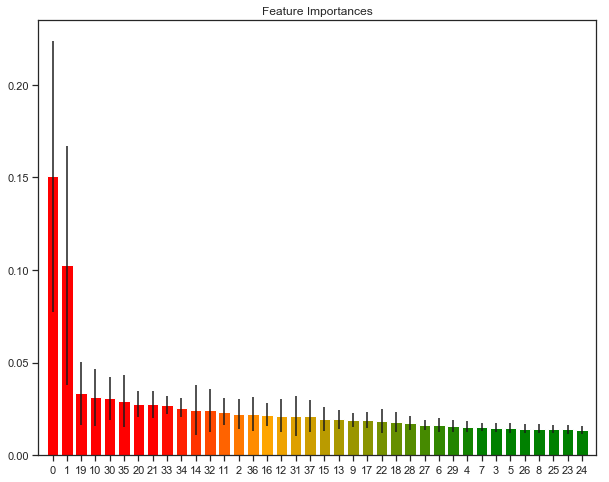

The number of components:  38


In [31]:
# Finding the most important features using Random Forest
forest = ExtraTreesClassifier(n_estimators=100, random_state=0)
label_train = np.concatenate(([1]*n_ALL, [0]*n_hem), axis=0) # labels: 1=ALL  0=hem
forest.fit(train_data, label_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for i in range(train_data.shape[1]):
    print("%d. F%d: %s (%f)" % (i + 1, indices[i]+1, features[indices[i]], importances[indices[i]]))

# Plot the feature importances of the forest
clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
N = 60
x = np.arange(N).astype(float)
y = np.random.uniform(0, 5, size=(N,))

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
plt.bar(range(train_data.shape[1]), importances[indices],
        color=rvb(x/N), yerr=std[indices], align="center")
plt.xticks(range(train_data.shape[1]), indices)
plt.xlim([-1, train_data.shape[1]])
plt.show()

# Find the number of components
cum_importance = importances[indices].cumsum()/importances.sum()
n_components = np.sum(cum_importance < .99) + 1
print("The number of components: ", n_components)

In [17]:
# Reduce train data to the first 16 important features
n_features = 5
RF_train_data = train_data[:,indices[:n_features]]

# Conversion of data from numpy array to dataframe
RF_train_data_df = pd.DataFrame.from_records(RF_train_data)
RF_train_data_df.columns = tuple(features[i] for i in indices[:n_features])
label_train = np.concatenate(([1]*n_ALL,[0]*n_hem), axis=0) 
RF_train_data_df.insert(5,"Label",label_train,True)
RF_train_data_df

# save train_data_df as a csv file
#RF_train_data_df.to_csv('Data/RF_train_data')
RF_train_data_df

,Cell Size,Perimeter,Haralick Difference Entropy,Haralick Contrast,Red Mean,Label
0,0.837601,0.314550,0.261523,0.167975,0.361517,1
1,0.587318,0.359125,0.401331,0.376405,0.390337,1
2,0.785577,0.370900,0.365521,0.160268,0.501905,1
3,0.451474,0.186712,0.394068,0.235165,0.318079,1
4,0.608631,0.225399,0.695308,0.401297,0.421780,1
5,0.697439,0.254836,0.617579,0.361897,0.684556,1
6,0.439167,0.216148,0.346074,0.247791,0.548840,1
7,0.541160,0.195963,0.413293,0.246263,0.405301,1
8,0.472464,0.179983,0.471991,0.304351,0.357267,1
9,0.651026,0.274180,0.283365,0.260237,0.502251,1


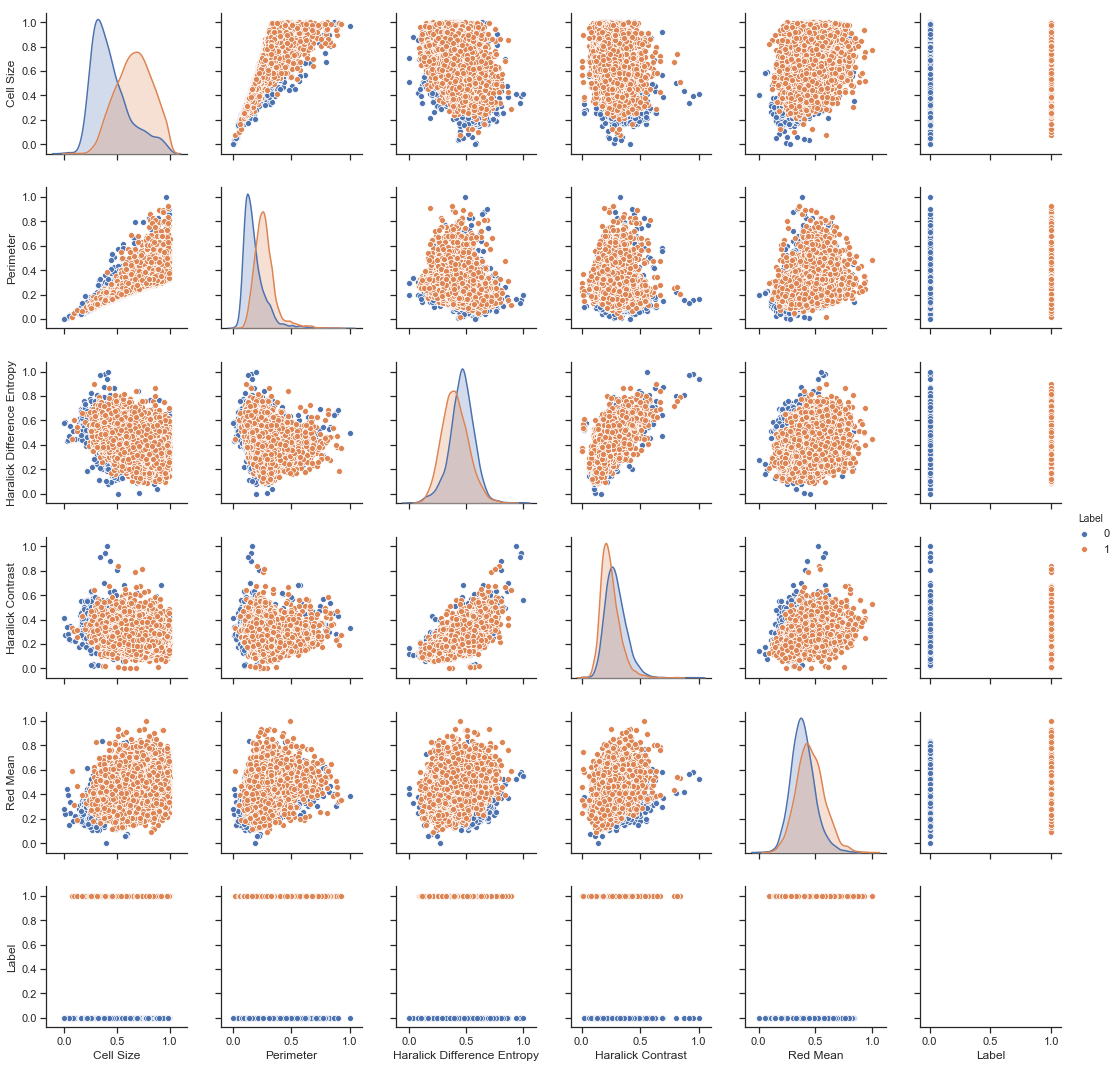

In [18]:
# Data visualization
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(RF_train_data_df,hue="Label")

Text(0.5, 0, 'Haralick Difference Entropy')

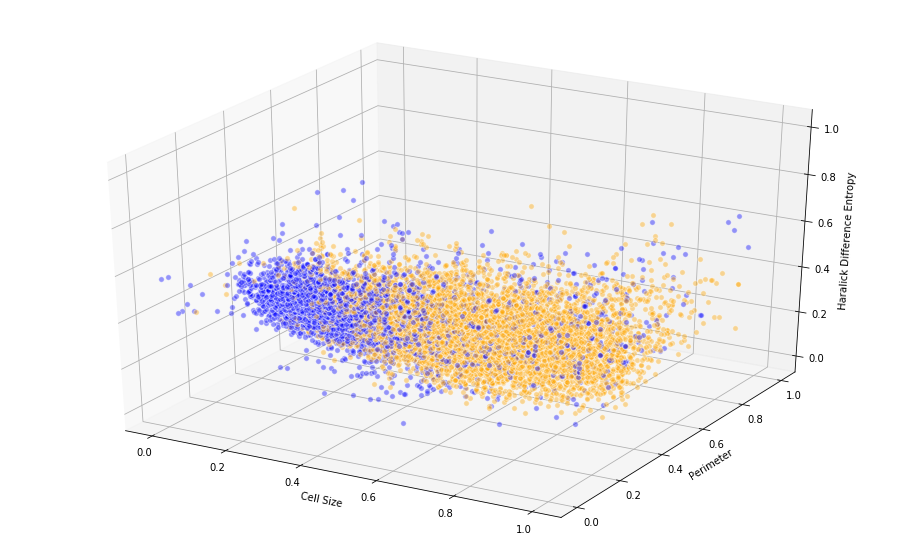

In [5]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
df = RF_train_data_df.sample(frac=1)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
xs = list(RF_train_data_df['Cell Size'])
ys = list(RF_train_data_df['Perimeter'])
zs = list(RF_train_data_df['Haralick Difference Entropy'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['orange' if i == 1 else 'blue' for i in list(RF_train_data_df['Label'])]
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z,s=30, alpha=0.4, c=color, edgecolors='w')

ax.set_xlabel('Cell Size')
ax.set_ylabel('Perimeter')
ax.set_zlabel('Haralick Difference Entropy')

In [6]:
## Visualization of top 3 features
# Trace of ALL
x = RF_train_data_df['Cell Size']
y = RF_train_data_df['Perimeter']
z = RF_train_data_df['Haralick Difference Entropy']
ALL = go.Scatter3d(
        x = x[:n_ALL],
        y = y[:n_ALL],
        z = z[:n_ALL],
        opacity = 0.5,
        name = 'ALL',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgb(255,102,102)',
            line = dict(
                color = 'rgb(204,102,102)',
                width = 2)))
# Trace of hem
Normal = go.Scatter3d(
        x = x[n_ALL:],
        y = y[n_ALL:],
        z = z[n_ALL:],
        opacity = 0.5,
        name = 'Normal',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgb(102,153,255)',
            line = dict(
                color = 'rgb(000,102,204)',
                width = 2)))
data = [ALL, Normal]
layout = go.Layout(
        scene = dict(
        xaxis = dict(
                title='Cell Size'),
         yaxis = dict(
                title='Perimeter'),
        zaxis = dict(
                title='Haralick Difference Entropy'),),
        width=700,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Top3features_scatter3D')

C:\Users\1000j\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [7]:
# Reduce test data to the first 16 important features
RF_test_data = test_data[:,indices[:n_features]]

# Conversion of data from numpy array to dataframe
RF_test_data_df = pd.DataFrame.from_records(RF_test_data)
RF_test_data_df.columns = tuple(features[i] for i in indices[:n_features])

# insert labels for test data 
RF_test_data_df.insert(0,"Label",label_test,True)

# save train_data_df as a csv file
RF_test_data_df.to_csv('RF_test_data')
RF_test_data_df

,Label,Cell Size,Perimeter,Haralick Difference Entropy,Haralick Contrast,Red Mean,Value Mean,Haralick Information Measures of Correlation 1,Haralick Information Measures of Correlation 2,Hue Mean,Saturation Mean,Haralick Sum Average,Blue Mean,Haralick Correlation,Form Factor,Intensity Mean,Haralick Sum Entropy
0,1,0.883714,0.312027,0.163331,0.109715,0.240324,0.238211,0.544695,0.533904,0.450813,0.791309,0.177412,0.243038,0.424270,0.868464,0.177943,0.090660
1,1,0.609393,0.244743,0.302094,0.187068,0.268241,0.264299,0.569775,0.614978,0.322071,0.844458,0.162764,0.204609,0.455270,0.803981,0.163229,0.199687
2,1,0.990971,0.408747,0.257707,0.215264,0.467291,0.461271,0.445506,0.782390,0.373925,0.723956,0.341252,0.391821,0.492825,0.657580,0.342176,0.321607
3,0,0.665389,0.293524,0.244502,0.245911,0.352083,0.360430,0.232248,0.925790,0.519724,0.518849,0.336352,0.372233,0.676229,0.693869,0.336974,0.488459
4,1,0.469023,0.187553,0.627771,0.330802,0.602013,0.594637,0.472023,0.881708,0.370126,0.546470,0.488891,0.505918,0.637791,0.840364,0.489987,0.611118
5,1,0.643129,0.240538,0.313637,0.202521,0.403336,0.396680,0.509611,0.697147,0.272198,0.788365,0.257603,0.285129,0.435061,0.868063,0.258452,0.243390
6,0,0.564251,0.343146,0.542875,0.540258,0.501123,0.494890,0.456121,0.878218,0.383302,0.596494,0.406646,0.429854,0.628531,0.449968,0.407505,0.549530
7,0,0.795761,0.481918,0.378593,0.359482,0.570120,0.565088,0.345597,0.902092,0.400870,0.562057,0.466559,0.495420,0.482071,0.363716,0.466608,0.523506
8,1,0.564874,0.227923,0.584289,0.457557,0.552054,0.544327,0.472291,0.878425,0.303676,0.565960,0.436625,0.439891,0.603668,0.811163,0.438080,0.586873
9,1,0.728566,0.258200,0.483419,0.182110,0.406792,0.408253,0.488718,0.803832,0.400111,0.635304,0.325325,0.357960,0.654952,0.905607,0.326673,0.432273


# Dimension Reduction Using PCA


The number of principal components necessary to recover 99% of variance: 19


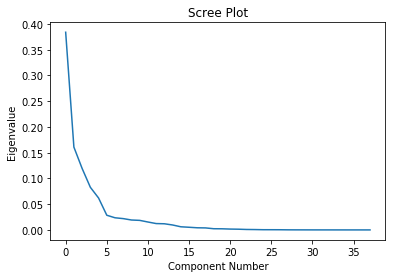

In [8]:
# Dimension reduction using PCA
D = np.size(train_data[1])
pca = PCA(n_components = D)
pca.fit(train_data)  
PCA(copy=True, iterated_power='auto', n_components = D, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)
plt.plot(pca.explained_variance_ratio_) 
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
n_components = np.sum((pca.explained_variance_ratio_.cumsum()/pca.explained_variance_ratio_.sum()) < 0.99)+1
print('The number of principal components necessary to recover 99% of variance:',n_components)

In [9]:
# choose number of components from the elbow test
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(train_data)  
PCA_train_data = pca.fit_transform(train_data)
print('Shape of train data: ', np.shape(PCA_train_data))
PCA_test_data = pca.transform(test_data)
PCA_test_data

Shape of train data:  (10661, 6)


array([[-0.60662965,  0.4855815 , -0.28974858,  0.45608259, -0.31786905,
         0.05662614],
       [-0.5989866 ,  0.15880647, -0.10104734,  0.22022657, -0.19735939,
         0.08843134],
       [ 0.16594286,  0.47829438,  0.09641472,  0.36808436, -0.1993427 ,
        -0.15933415],
       ...,
       [ 0.05324623,  0.28356206, -0.52556994,  0.0946701 ,  0.1563115 ,
         0.02150127],
       [-0.11362081, -0.29955925,  0.09937755, -0.3056476 , -0.20568336,
        -0.04270861],
       [-0.01745455, -0.07687245, -0.00669816, -0.14903576, -0.24294784,
         0.37046916]])

In [10]:
# Conversion of data from numpy array to dataframe
PCA_train_data_df = pd.DataFrame.from_records(PCA_train_data)
PCA_train_data_df.columns = tuple('PC'+str(num+1) for num in range(np.size(PCA_train_data[1])))
PCA_train_data_df.insert(0,"Label",label_train,True)

# save train_data_df as a csv file
#PCA_train_data_df.to_csv('Data/PCA_train_data.csv')
PCA_train_data_df

,Label,PC1,PC2,PC3,PC4,PC5,PC6
0,1,-0.064766,0.471292,-0.204569,-0.169578,-0.085430,0.013529
1,1,0.024316,0.265480,0.384610,-0.093437,-0.005898,0.149535
2,1,0.655120,0.221769,0.150813,-0.026695,0.005935,-0.029795
3,1,-0.602065,0.080955,0.017394,0.203243,-0.010179,0.003583
4,1,-0.176473,-0.682502,0.170947,0.114972,-0.418016,-0.004419
5,1,0.685412,-0.488732,-0.050503,-0.218191,-0.035820,-0.045019
6,1,0.433701,0.218635,0.211627,-0.151788,0.411020,-0.115642
7,1,-0.332345,-0.093706,-0.176426,0.085063,-0.062572,0.020012
8,1,-0.295591,-0.082965,0.122744,0.009383,0.013987,-0.071549
9,1,-0.079181,0.214349,-0.021534,0.087172,0.019035,-0.069136


Text(0.5, 0, 'PC3')

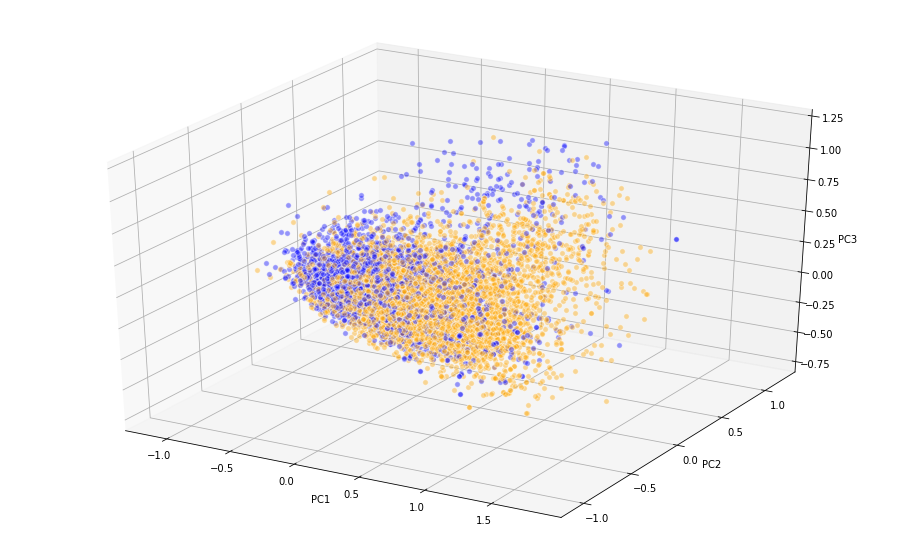

In [11]:
# Visualizing 3-D numeric data with Scatter Plots
# PC1, PC2 and PC3
df = PCA_train_data_df.sample(frac=1)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')
xs = list(PCA_train_data_df['PC1'])
ys = list(PCA_train_data_df['PC2'])
zs = list(PCA_train_data_df['PC3'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['orange' if i == 1 else 'blue' for i in list(RF_train_data_df['Label'])]
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z,s=30, alpha=0.4, c=color, edgecolors='w')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [12]:
# Conversion of data from numpy array to dataframe
PCA_test_data_df = pd.DataFrame.from_records(PCA_test_data)
PCA_test_data_df.columns = tuple('PC'+str(num+1) for num in range(np.size(PCA_test_data[1])))

# insert labels for test data 
PCA_test_data_df.insert(0,"Label",label_test,True)

# save test_data_df as a csv file
#PCA_test_data_df.to_csv('Data/PCA_test_data.csv')
PCA_test_data_df

,Label,PC1,PC2,PC3,PC4,PC5,PC6
0,1,-0.606630,0.485581,-0.289749,0.456083,-0.317869,0.056626
1,1,-0.598987,0.158806,-0.101047,0.220227,-0.197359,0.088431
2,1,0.165943,0.478294,0.096415,0.368084,-0.199343,-0.159334
3,0,0.204588,0.452552,0.147284,0.010783,0.147157,-0.043995
4,1,0.503868,-0.310912,0.243184,-0.012567,0.234192,-0.173951
5,1,-0.367705,0.070248,-0.232382,0.199644,-0.115474,0.077759
6,0,0.418473,-0.144048,0.388408,-0.095571,0.029611,0.122243
7,0,0.661105,0.337489,0.342668,0.278384,0.057059,0.037946
8,1,0.373550,-0.381073,0.118010,-0.143662,0.051194,-0.043375
9,1,-0.023590,-0.122945,-0.250716,-0.097413,-0.194245,0.039306


In [13]:
## Visualization of top 3 principle components
# Trace of ALL
x = PCA_train_data_df['PC1']
y = PCA_train_data_df['PC2']
z = PCA_train_data_df['PC3']
ALL = go.Scatter3d(
        x = x[:n_ALL],
        y = y[:n_ALL],
        z = z[:n_ALL],
        opacity = 0.5,
        name = 'ALL',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgb(255,102,102)',
            line = dict(
                color = 'rgb(204,102,102)',
                width = 2)))
# Trace of hem
Normal = go.Scatter3d(
        x = x[n_ALL:],
        y = y[n_ALL:],
        z = z[n_ALL:],
        opacity = 0.5,
        name = 'Normal',
        mode = 'markers',
        marker = dict(
            size = 5,
            color = 'rgb(102,153,255)',
            line = dict(
                color = 'rgb(000,102,204)',
                width = 2)))
data = [ALL, Normal]
layout = go.Layout(
        scene = dict(
        xaxis = dict(
                title='PC1'),
         yaxis = dict(
                title='PC2'),
        zaxis = dict(
                title='PC3'),),
        width=700,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Top3PC_scatter3D')

C:\Users\1000j\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

